GIF guardado como 'evolution.gif' en la ruta del proyecto.


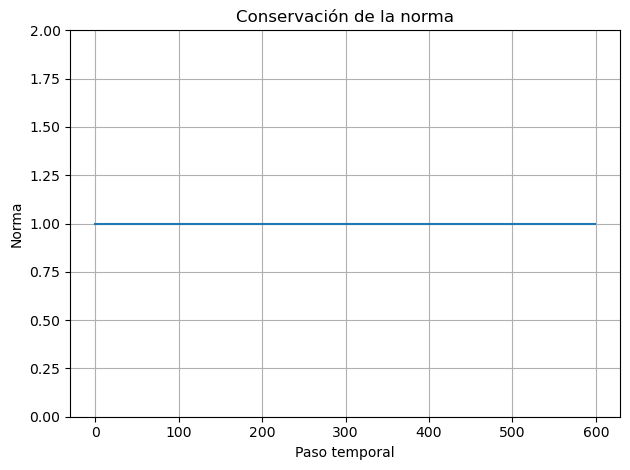

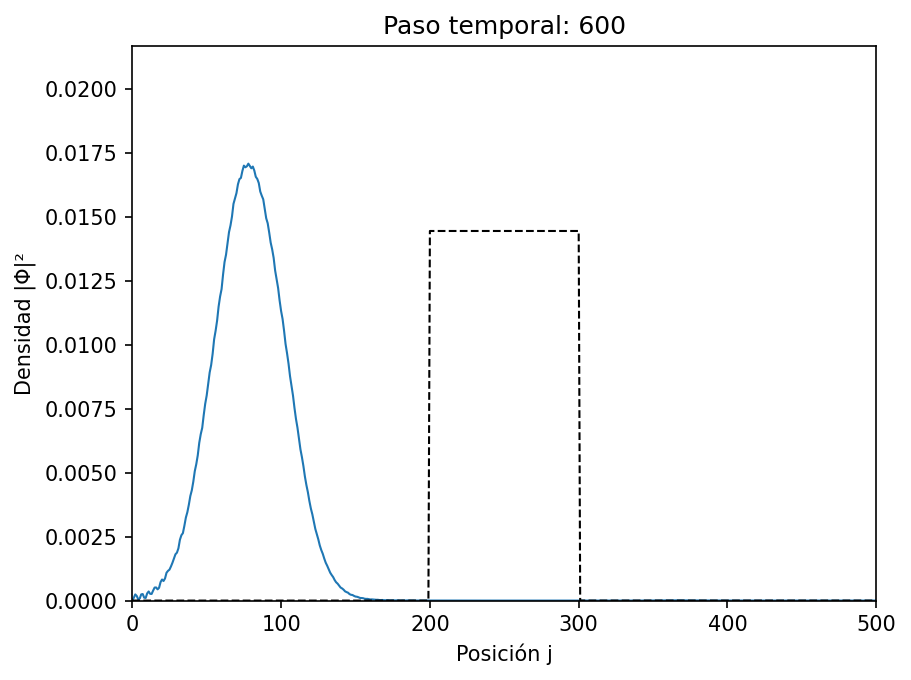

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from numba import njit

# =============================================================
# Simulación de la ecuación de Schrödinger 1D
# Método de Crank-Nicolson (aproximación de Cayley) con animación
# =============================================================

# 1. Parámetros iniciales
def initialize_parameters(N, nciclos, lam):
    k0_tilde = 2 * np.pi * nciclos / N
    V_tilde = np.zeros(N + 1, dtype=np.float64)  # ✅ tipo explícito
    j1, j2 = int(2 * N / 5), int(3 * N / 5)
    V_tilde[j1:j2 + 1] = lam * k0_tilde ** 2
    s_tilde = 1 / (4 * k0_tilde ** 2)
    return k0_tilde, V_tilde, s_tilde

# 2. Función de onda inicial
def initialize_wave(N, k0_tilde):
    phi = np.zeros(N + 1, dtype=complex)
    j = np.arange(1, N)
    phase = np.exp(1j * k0_tilde * j)
    envelope = np.exp(-8 * (4 * j - N) ** 2 / N ** 2)
    phi[1:N] = phase * envelope
    phi[0] = phi[N] = 0  # Condiciones de frontera
    # Normalizar la función de onda
    norm = np.sqrt(np.sum(np.abs(phi)**2))
    phi /= norm
    return phi

# 3. Coeficientes alpha
@njit
def compute_alpha(N, V_tilde, s_tilde):
    alpha = np.zeros(N + 1, dtype=np.complex128)
    alpha[N - 1] = 0.0 + 0.0j
    for j in range(N - 1, 0, -1):
        A0 = -2.0 + 2.0j / s_tilde - V_tilde[j]
        gamma = 1.0 / (A0 + alpha[j])
        alpha[j - 1] = -gamma
    return alpha

# 4. Evolución temporal
@njit
def time_evolution(phi0, alpha, V_tilde, s_tilde, n_steps=600):
    N = len(phi0) - 1
    phi = phi0.copy()
    phis = np.zeros((n_steps, N + 1), dtype=np.complex128)  # ✅ matriz en lugar de lista

    for n in range(n_steps):
        beta = np.zeros(N + 1, dtype=np.complex128)
        beta[N - 1] = 0.0 + 0.0j
        for j in range(N - 1, 0, -1):
            A0 = -2.0 + 2.0j / s_tilde - V_tilde[j]
            rhs = 4.0j * phi[j] / s_tilde
            beta[j - 1] = (rhs - beta[j]) / (A0 + alpha[j])

        chi = np.zeros(N + 1, dtype=np.complex128)
        for j in range(0, N):
            chi[j + 1] = alpha[j] * chi[j] + beta[j]

        phi = chi - phi
        phi /= np.sqrt(np.sum(np.abs(phi)**2))  # normalización
        phis[n] = phi  # ✅ guardamos el paso en la matriz

    return phis

# 5. Conservación de norma
def plot_norm_conservation(phis):
    norms = [np.sum(np.abs(phi)**2) for phi in phis]
    plt.figure()
    plt.plot(norms)
    plt.title('Conservación de la norma')
    plt.xlabel('Paso temporal')
    plt.ylabel('Norma')
    plt.grid(True)
    plt.ylim(0, 2)
    plt.tight_layout()


# 6. Simulación y animación
def run_simulation_and_animate(save_gif=True, gif_name='evolution.gif', plot_norm=True):
    N, nciclos, lam = 500, 60, 1.5
    k0_tilde, V_tilde, s_tilde = initialize_parameters(N, nciclos, lam)
    phi0 = initialize_wave(N, k0_tilde)
    alpha = compute_alpha(N, V_tilde, s_tilde)
    phis = time_evolution(phi0, alpha, V_tilde, s_tilde, n_steps=600)

    if plot_norm:
        plot_norm_conservation(phis)

    # Preparar animación
    fig, ax = plt.subplots(dpi=150)
    x = np.arange(N + 1)
    potential_scale = np.max(np.abs(phi0)**2) / np.max(V_tilde) * 0.8 if np.max(V_tilde) > 0 else 1
    line_wave, = ax.plot([], [], lw=1)
    line_pot, = ax.plot(x, V_tilde * potential_scale, 'k--', lw=1)
    ax.set_xlim(0, N)
    ax.set_ylim(0, np.max(np.abs(phi0)**2) * 1.2)
    ax.set_xlabel('Posición j')
    ax.set_ylabel('Densidad |Φ|²')
    ax.set_title('Evolución de paquete de onda')

    def update(frame):
        phi = phis[frame]
        y = np.abs(phi)**2
        line_wave.set_data(x, y)
        ax.set_title(f'Paso temporal: {frame + 1}')
        return [line_wave]

    anim = FuncAnimation(fig, update, frames=len(phis), blit=True, interval=50)

    if save_gif:
        writer = PillowWriter(fps=20)
        anim.save(gif_name, writer=writer)
        print(f"GIF guardado como '{gif_name}' en la ruta del proyecto.")
    else:
        plt.show()

# =============================================================
# Ejecutar simulación
# =============================================================
if __name__ == '__main__':
    run_simulation_and_animate()
